In [1]:
import numpy as np
import scipy.ndimage
import astropy.io.fits as fits
import matplotlib.pyplot as plt
import os
%pylab inline --no-import-all
matplotlib.rcParams['image.origin'] = 'lower'
matplotlib.rcParams['image.interpolation'] = 'nearest' 
matplotlib.rcParams['image.cmap'] = 'gray'

Populating the interactive namespace from numpy and matplotlib


## Set basic parameters

In [2]:
N = 300
inD = 0.3
outD = 0.9
spad = 0.02

## Load an example telescope aperture and secondary obscuration

In [3]:
telap_dir = os.path.abspath('../Apertures/JPL/offset_masks')
telap_fname = os.path.join(telap_dir, "hex3_1000pix_offset.fits")
secobs_fname = os.path.join(telap_dir, "x_spiders_1000pix_2.5cm_offset.fits")
telap_hdulist = fits.open(telap_fname, "readonly")
telap_orig = telap_hdulist[0].data
telap_hdulist.close()
secobs_hdulist = fits.open(secobs_fname, "readonly")
secobs = secobs_hdulist[0].data
secobs_hdulist.close()

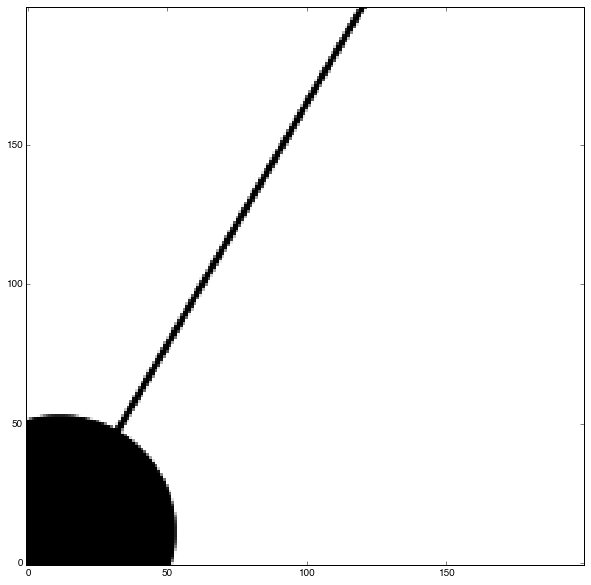

In [4]:
plt.figure(figsize=(10,10))
plt.imshow(secobs[500:700,500:700])

## Pad the secondary obscuration

In [5]:
D = 1000
max_shift = int(round(D*spad))
shift_range = range(-max_shift,max_shift+1,4)

In [6]:
[Xshifts, Yshifts] = np.meshgrid(shift_range, shift_range)

In [7]:
allowed_shifts = np.less_equal(Xshifts**2 + Yshifts**2, max_shift**2)

In [8]:
allowed_shifts.shape

(11, 11)

In [9]:
XYshifts_allowed = zip(Xshifts[allowed_shifts], Yshifts[allowed_shifts])

In [10]:
len(XYshifts_allowed)

81

In [11]:
padded_secobs_accum = np.ones(secobs.shape)
for (xshift,yshift) in XYshifts_allowed:
    secobs_shifted = np.roll(np.roll(secobs, yshift, 0), xshift, 1) 
    padded_secobs_accum *= secobs_shifted

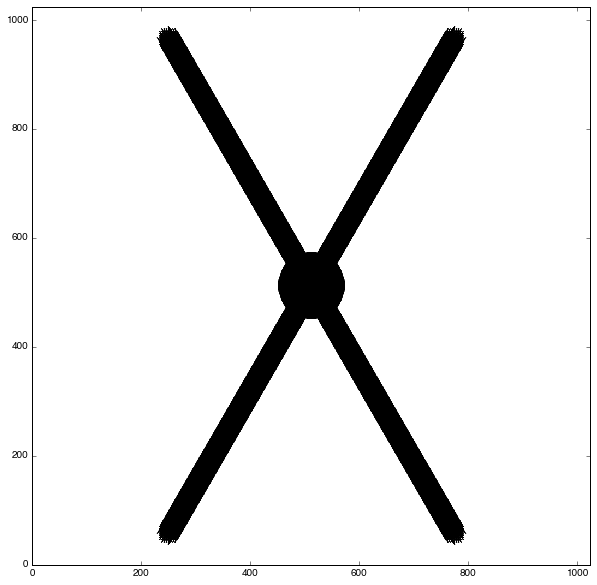

In [12]:
plt.figure(figsize=(10,10))
plt.imshow(padded_secobs_accum)

## Combine with annular stop

In [13]:
L = secobs.shape[0]
xs = np.linspace(-L/2 + 0.5, L/2 - 0.5, L)
[Xs, Ys] = np.meshgrid(xs, xs)
inside_ann = np.less_equal(Xs**2 + Ys**2, (inD*D/2)**2)
outside_ann = np.greater_equal(Xs**2 + Ys**2, (outD*D/2)**2)
Lyot_stop = np.round(padded_secobs_accum)
Lyot_stop[inside_ann] = 0.
Lyot_stop[outside_ann] = 0.

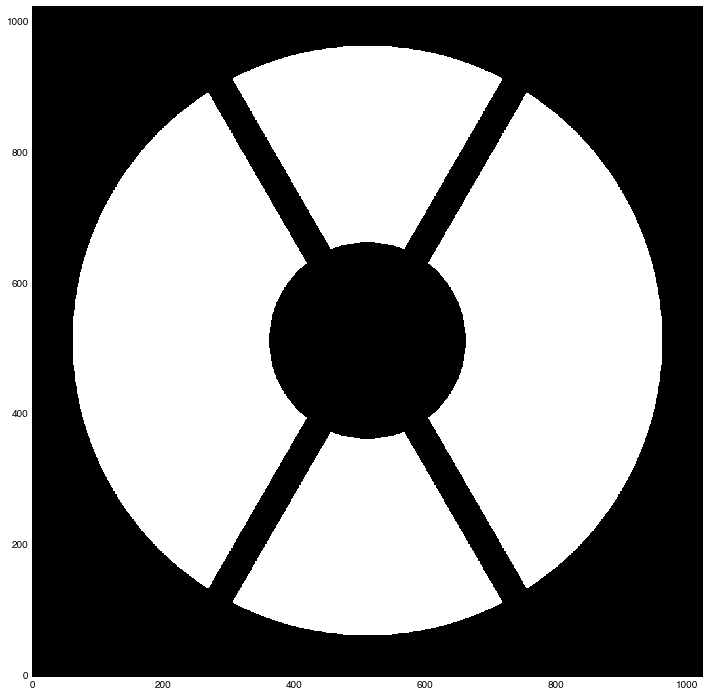

In [14]:
plt.figure(figsize=(12,12))
plt.imshow(Lyot_stop)

## Bin to final array resolution, crop

In [15]:
scalefac = float(N)/(D/2)
Lyot_stop_binned = scipy.ndimage.zoom(Lyot_stop, scalefac, order=1)

In [16]:
L_bin = Lyot_stop_binned.shape[0]
Lyot_stop_binned_quad = Lyot_stop_binned[L_bin/2:L_bin/2+N,L_bin/2:L_bin/2+N]
Lyot_stop_binned_quad.shape

(300, 300)

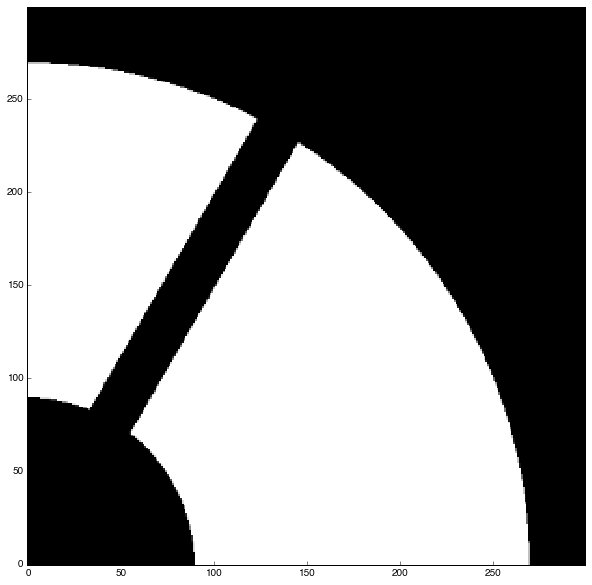

In [17]:
plt.figure(figsize=(10,10))
plt.imshow(Lyot_stop_binned_quad)